# Analysis of extractive structures results

### Imports

In [1]:
%load_ext autoreload
%autoreload 2
# Add the top level of the directory to the python path, so we can import the scripts
import sys
from pathlib import Path
import os
import torch

repo_root = str(Path(".").absolute().parent)
if repo_root not in sys.path:
    sys.path.append(repo_root)
# Also chang the CWD to the repo
os.chdir(repo_root)
from oocr_influence.logging import load_experiment_checkpoint

# from examples.mnist.pipeline import get_mnist_dataset, construct_mnist_classifier, add_box_to_mnist_dataset

import logging
from typing import Literal
import torch
import torch.nn.functional as F
from transformers import GPT2LMHeadModel, Conv1D
from torch import nn
from pathlib import Path
from kronfluence.analyzer import Analyzer, prepare_model
from datasets import Dataset
from kronfluence.arguments import FactorArguments, ScoreArguments
from kronfluence.task import Task
from kronfluence.utils.common.factor_arguments import all_low_precision_factor_arguments
from kronfluence.utils.common.score_arguments import all_low_precision_score_arguments
from kronfluence.utils.dataset import DataLoaderKwargs
from oocr_influence.datasets.utils import get_data_collator_with_padding
from oocr_influence.logging import load_experiment_checkpoint
from datetime import datetime
from matplotlib.figure import Figure
from matplotlib.axes import Axes

# from examples.mnist.pipeline import get_mnist_dataset, construct_mnist_classifier, add_box_to_mnist_dataset

/mfs1/u/max/oocr-influence/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mfs1/u/max/oocr-influence/.venv/lib/python3.12/site-packages/pydantic/_internal/_config.py:345: UserWarning: Valid config keys have changed in V2:
* 'allow_mutation' has been removed
  warnings.warn(message, UserWarning)


In [4]:
__file__

NameError: name '__file__' is not defined

### Learning rate sweep

In [2]:
learning_rate_sweep_files = [
    "outputs_for_plots/lr_sweep_26_2/2025_02_27_00-44-00_lr_sweep_to_reproduce_results_index_1_num_facts_20_hop_first_num_epochs_10_lr_1e-06",
    "outputs_for_plots/lr_sweep_26_2/2025_02_27_00-43-57_lr_sweep_to_reproduce_results_index_5_num_facts_20_hop_first_num_epochs_10_lr_1e-05",
    "outputs_for_plots/lr_sweep_26_2/2025_02_27_00-43-57_lr_sweep_to_reproduce_results_index_6_num_facts_20_hop_first_num_epochs_10_lr_3e-05",
    "outputs_for_plots/lr_sweep_26_2/2025_02_27_00-43-58_lr_sweep_to_reproduce_results_index_7_num_facts_20_hop_first_num_epochs_10_lr_3e-05",
    "outputs_for_plots/lr_sweep_26_2/2025_02_27_00-43-59_lr_sweep_to_reproduce_results_index_0_num_facts_20_hop_first_num_epochs_10_lr_1e-06",
    "outputs_for_plots/lr_sweep_26_2/2025_02_27_00-44-00_lr_sweep_to_reproduce_results_index_2_num_facts_20_hop_first_num_epochs_10_lr_3e-06",
    "outputs_for_plots/lr_sweep_26_2/2025_02_27_00-44-00_lr_sweep_to_reproduce_results_index_3_num_facts_20_hop_first_num_epochs_10_lr_3e-06",
    "outputs_for_plots/lr_sweep_26_2/2025_02_27_00-44-01_lr_sweep_to_reproduce_results_index_4_num_facts_20_hop_first_num_epochs_10_lr_1e-05",
]

In [3]:
import matplotlib.pyplot as plt
import numpy as np


def analyze_learning_rate_sweep(experiment_files):
    """
    Analyze learning rate sweep experiments and create plots for training loss and mean ranks.

    Args:
        experiment_files: List of paths to experiment output directories

    Returns:
        tuple: (loss_figure, rank_figure) containing the matplotlib figures
    """
    # Dictionary to store data for each experiment
    experiment_data = {}

    for experiment_output_dir in experiment_files:
        _, train_dataset, test_dataset, tokenizer, experiment_log = (
            load_experiment_checkpoint(
                experiment_output_dir=Path(experiment_output_dir).absolute(),
                checkpoint_name="checkpoint_final",
                load_model=False,
                load_tokenizer=False,
            )
        )

        args = experiment_log.log_dict["training_args"]
        lr = args["learning_rate"]
        scheduler = args["lr_scheduler"]

        # Create a unique key for this experiment
        key = f"{lr}_{scheduler}"

        if key not in experiment_data:
            experiment_data[key] = {
                "learning_rate": lr,
                "scheduler": scheduler,
                "epochs": [],
                "losses": [],
                "ranks": [],
            }

        # Extract epoch numbers, train losses, and ranks
        for history_entry in experiment_log.history:
            experiment_data[key]["epochs"].append(history_entry["epoch_num"])
            experiment_data[key]["losses"].append(history_entry["train_loss"])
            experiment_data[key]["ranks"].append(
                history_entry["eval_results"]["test_set"]["ranks"]
            )

    # Create a grid of plots based on unique learning rates and schedulers
    learning_rates = sorted(
        list(set([data["learning_rate"] for data in experiment_data.values()]))
    )
    schedulers = sorted(
        list(set([data["scheduler"] for data in experiment_data.values()]))
    )

    # Create figure for training loss
    fig_loss = plt.figure(figsize=(15, 8))
    fig_loss.suptitle(
        "Training Loss vs Epoch for Different Learning Rates and Schedulers"
    )

    # Create figure for mean ranks
    fig_rank = plt.figure(figsize=(15, 8))
    fig_rank.suptitle("Mean Rank vs Epoch for Different Learning Rates and Schedulers")

    # Create subplot grids
    axes_loss = fig_loss.subplots(
        len(schedulers), len(learning_rates), sharex=True, sharey=True
    )
    axes_rank = fig_rank.subplots(
        len(schedulers), len(learning_rates), sharex=True, sharey=True
    )

    # If there's only one scheduler or learning rate, make sure axes are 2D
    if len(schedulers) == 1:
        axes_loss = np.array([axes_loss])
        axes_rank = np.array([axes_rank])
    if len(learning_rates) == 1:
        axes_loss = np.array([axes_loss]).T
        axes_rank = np.array([axes_rank]).T

    # Plot training loss
    for i, scheduler in enumerate(schedulers):
        for j, lr in enumerate(learning_rates):
            key = f"{lr}_{scheduler}"
            if key in experiment_data:
                data = experiment_data[key]
                axes_loss[i, j].plot(data["epochs"], data["losses"], "o-")
                axes_loss[i, j].set_title(f"LR: {lr}, Scheduler: {scheduler}")
                axes_loss[i, j].grid(True)

            # Add labels only to the outer plots
            if i == len(schedulers) - 1:
                axes_loss[i, j].set_xlabel("Epoch")
            if j == 0:
                axes_loss[i, j].set_ylabel("Train Loss")

    # Plot mean ranks
    for i, scheduler in enumerate(schedulers):
        for j, lr in enumerate(learning_rates):
            key = f"{lr}_{scheduler}"
            if key in experiment_data:
                data = experiment_data[key]
                # Calculate mean ranks for each epoch
                mean_ranks = []
                for ranks in data["ranks"]:
                    # Extract the actual rank values from the pickled paths
                    rank_values = []
                    for rank_path in ranks:
                        if isinstance(rank_path, str) and rank_path.startswith(
                            "pickled://"
                        ):
                            # Extract the number from the filename
                            filename = rank_path.split("/")[-1]
                            rank_value = int(filename.split(".")[0])
                            rank_values.append(rank_value)
                        elif isinstance(rank_path, int):
                            rank_values.append(rank_path)

                    if rank_values:
                        mean_ranks.append(np.mean(rank_values))

                # Plot mean ranks
                axes_rank[i, j].plot(data["epochs"], mean_ranks, "o-")
                axes_rank[i, j].set_title(f"LR: {lr}, Scheduler: {scheduler}")
                axes_rank[i, j].grid(True)

            # Add labels only to the outer plots
            if i == len(schedulers) - 1:
                axes_rank[i, j].set_xlabel("Epoch")
            if j == 0:
                axes_rank[i, j].set_ylabel("Mean Rank")

    # Adjust layout
    fig_loss.tight_layout(rect=(0, 0, 1, 0.95))
    fig_rank.tight_layout(rect=(0, 0, 1, 0.95))

    return fig_loss, fig_rank


loss_fig, rank_fig = analyze_learning_rate_sweep(learning_rate_sweep_files)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/mfs1/u/max/outputs_for_plots/lr_sweep_26_2/2025_02_27_00-44-00_lr_sweep_to_reproduce_results_index_1_num_facts_20_hop_first_num_epochs_10_lr_1e-06/experiment_log.json'

Experiment data structure:
lr-sweep-1e-05: 5 epochs, 5 logprobs, 5 probs
Sample logprobs: [-1.669468879699707, -1.0012725591659546, -0.9287945628166199]
Sample probs: [0.18834707403267126, 0.3674115905635398, 0.39502960685895805]


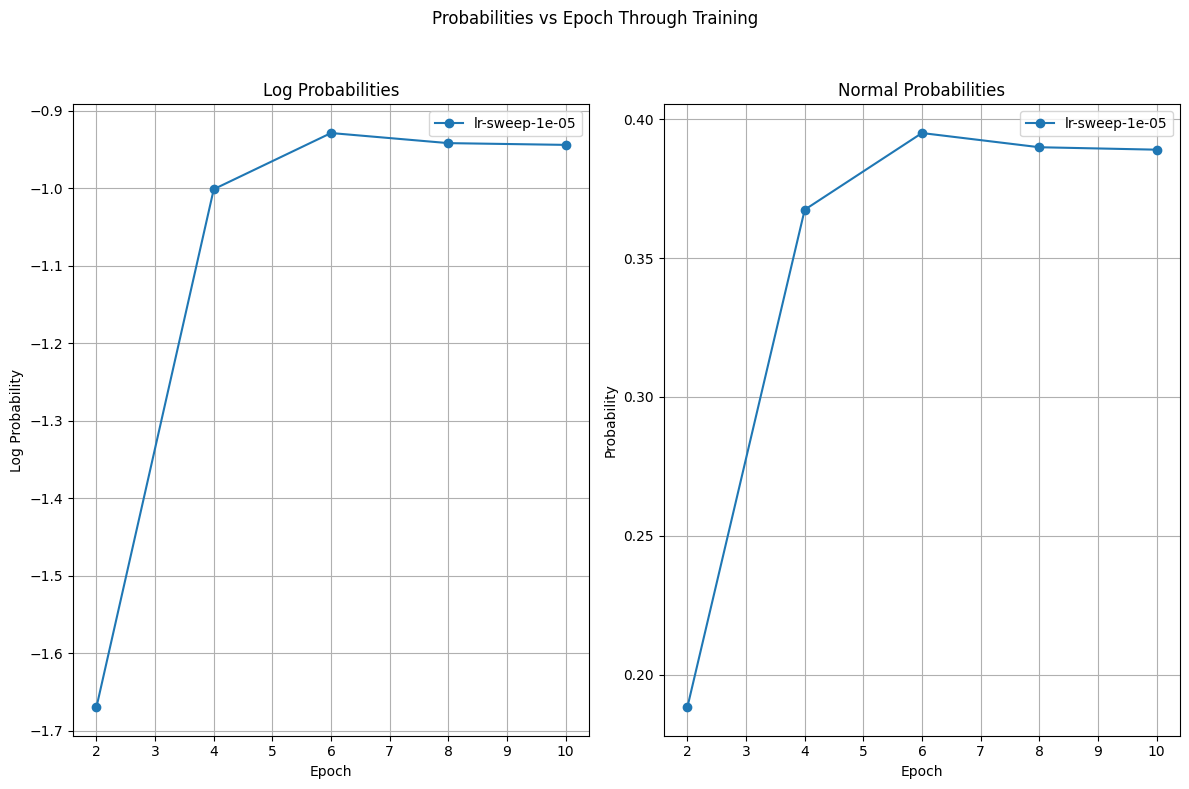

In [42]:
def analyze_logprobs(
    experiment_files: list[str], experiment_names: list[str] | None = None
):
    """
    Analyze and plot the log probabilities and normal probabilities from experiments through training.

    Args:
        experiment_files: List of paths to experiment output directories

    Returns:
        matplotlib figure containing the log probability and normal probability plots
    """
    # Dictionary to store data for each experiment
    experiment_data = {}

    experiment_names = experiment_names or [
        Path(experiment_output_dir).name for experiment_output_dir in experiment_files
    ]

    for experiment_output_dir, experiment_name in zip(
        experiment_files, experiment_names
    ):
        _, train_dataset, test_dataset, tokenizer, experiment_log = (
            load_experiment_checkpoint(
                experiment_output_dir=Path(experiment_output_dir).absolute(),
                checkpoint_name="checkpoint_final",
                load_model=False,
                load_tokenizer=False,
            )
        )

        if experiment_name not in experiment_data:
            experiment_data[experiment_name] = {
                "epochs": [],
                "logprobs": [],
                "probs": [],  # Added normal probabilities
            }

        # Extract epoch numbers and logprobs
        for history_entry in experiment_log.history:
            if (
                "eval_results" in history_entry
                and "test_set" in history_entry["eval_results"]
            ):
                # Check if the key exists before accessing it
                test_results = history_entry["eval_results"]["test_set"]
                if isinstance(test_results, dict) and "logprob" in test_results:
                    experiment_data[experiment_name]["epochs"].append(
                        history_entry["epoch_num"]
                    )
                    # Keep log probabilities
                    logprob = test_results["logprob"]
                    experiment_data[experiment_name]["logprobs"].append(logprob)
                    # Convert to normal probabilities
                    prob = np.exp(logprob)
                    experiment_data[experiment_name]["probs"].append(prob)

    # Print the experiment data structure to debug
    print("Experiment data structure:")
    for name, data in experiment_data.items():
        print(
            f"{name}: {len(data['epochs'])} epochs, {len(data['logprobs'])} logprobs, {len(data['probs'])} probs"
        )
        if data["logprobs"]:
            print(f"Sample logprobs: {data['logprobs'][:3]}")
            print(f"Sample probs: {data['probs'][:3]}")

    # Create figure for log probabilities and normal probabilities
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    fig.suptitle("Probabilities vs Epoch Through Training")

    # Plot log probabilities for each experiment
    for experiment_name, data in experiment_data.items():
        if data["epochs"] and data["logprobs"]:  # Make sure we have data to plot
            ax1.plot(data["epochs"], data["logprobs"], "o-", label=experiment_name)
            ax2.plot(data["epochs"], data["probs"], "o-", label=experiment_name)

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Log Probability")
    ax1.grid(True)
    ax1.legend()
    ax1.set_title("Log Probabilities")

    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Probability")
    ax2.grid(True)
    ax2.legend()
    ax2.set_title("Normal Probabilities")

    # Adjust layout
    fig.tight_layout(rect=(0, 0, 1, 0.95))

    return fig


fig = analyze_logprobs(
    [
        "/mfs1/u/max/oocr-influence/outputs/2025_02_27_02-04-21_lr_sweep_to_reproduce_results_index_0_num_facts_20_hop_first_num_epochs_10_lr_1e-05"
    ],
    ["lr-sweep-1e-05"],
)
fig.show()

## Influence analysis

In [9]:
BATCH_TYPE = dict[str, torch.Tensor]
import torch.nn as nn
import torch.nn.functional as F

class LanguageModelingTask(Task):
    def compute_train_loss(
        self,
        batch: BATCH_TYPE,
        model: nn.Module,
        sample: bool = False,
    ) -> torch.Tensor:
        logits = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
        ).logits
        logits = logits[..., :-1, :].contiguous()
        logits = logits.view(-1, logits.size(-1))

        if not sample:
            labels = batch["labels"]
            labels = labels[..., 1:].contiguous()
            summed_loss = F.cross_entropy(logits, labels.view(-1), reduction="sum")
        else:
            with torch.no_grad():
                probs = torch.nn.functional.softmax(logits.detach(), dim=-1)
                sampled_labels = torch.multinomial(
                    probs,
                    num_samples=1,
                ).flatten()
            summed_loss = F.cross_entropy(logits, sampled_labels, reduction="sum")
        return summed_loss

    def compute_measurement(
        self,
        batch: BATCH_TYPE,
        model: nn.Module,
    ) -> torch.Tensor:
        # We could also compute the log-likelihood or averaged margin.
        return self.compute_train_loss(batch, model)

    def get_influence_tracked_modulrges(self) -> list[str]:
        total_modules = []

        for i in range(8):
            total_modules.append(f"transformer.h.{i}.attn.c_attn")
            total_modules.append(f"transformer.h.{i}.attn.c_proj")

        for i in range(8):
            total_modules.append(f"transformer.h.{i}.mlp.c_fc")
            total_modules.append(f"transformer.h.{i}.mlp.c_proj")

        return total_modules

    def get_attention_mask(self, batch: BATCH_TYPE) -> torch.Tensor:
        return batch["attention_mask"]


class LanguageModelingTaskMargin(LanguageModelingTask):
    def compute_measurement(self, batch: BATCH_TYPE, model: nn.Module) -> torch.Tensor:
        # Copied from: https://github.com/MadryLab/trak/blob/main/trak/modelout_functions.py. Returns the margin between the correct logit and the second most likely prediction

        logits = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
        ).logits
        logits = logits[..., :-1, :].contiguous()
        logits = logits.view(-1, logits.size(-1))

        labels = batch["labels"][..., 1:].contiguous().view(-1)
        mask = labels != -100

        labels = labels[mask]
        logits = logits[mask]

        # Get correct logit values
        bindex = torch.arange(logits.shape[0]).to(
            device=logits.device, non_blocking=False
        )
        logits_correct = logits[bindex, labels]

        # Get the other logits, and take the softmax of them
        cloned_logits = logits.clone()
        cloned_logits[bindex, labels] = torch.tensor(
            -torch.inf, device=logits.device, dtype=logits.dtype
        )
        maximum_non_correct_logits = cloned_logits.logsumexp(dim=-1)

        # Look at the  margin, the difference between the correct logits and the (soft) maximum non-correctl logits
        margins = logits_correct - maximum_non_correct_logits
        return -margins.sum()

In [11]:
experiment_output_dir = Path(
     "/mfs1/u/max/oocr-influence/outputs/2025_02_27_02-04-21_lr_sweep_to_reproduce_results_index_0_num_facts_20_hop_first_num_epochs_10_lr_1e-05"
)
checkpoint_name = "checkpoint_final"

FACTOR_STRATEGY: Literal["identity", "diagonal", "kfac", "ekfac"] = (
    "ekfac"  # TODO: Add typesc for the
)
profile_computations = False
use_half_precision = False
compute_per_token_scores = False
use_compile = False
query_batch_size = 32
train_batch_size = 32
query_gradient_rank = -1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
@torch.no_grad()
def replace_conv1d_modules(model: nn.Module) -> None:
    # GPT-2 is defined in terms of Conv1D. However, this does not work for Kronfluence.
    # Here, we convert these Conv1D modules to linear modules recursively.
    for name, module in model.named_children():
        if len(list(module.children())) > 0:
            replace_conv1d_modules(module)

        if isinstance(module, Conv1D):
            new_module = nn.Linear(
                in_features=module.weight.shape[0], out_features=module.weight.shape[1]
            )
            new_module.weight.data.copy_(module.weight.data.t())
            new_module.bias.data.copy_(module.bias.data)
            setattr(model, name, new_module)


model_for_analysis, train_dataset, test_dataset, tokenizer, log = (
    load_experiment_checkpoint(experiment_output_dir, checkpoint_name,load_tokenizer=False)
)
replace_conv1d_modules(model_for_analysis)

model_for_inference = load_experiment_checkpoint(
    experiment_output_dir, checkpoint_name
)[0]
task = LanguageModelingTaskMargin()
model_for_analysis = prepare_model(model_for_analysis, task)

Loading checkpoint shards:  33%|███▎      | 1/3 [00:11<00:23, 11.90s/it]

: 

: 